In [1]:
import h5py
import numpy as np
import requests
import getpass
import socket
import json
import zipfile
import io
import math
from glob import glob
import os
import shutil
import pprint
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import re
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth


In [2]:
# View data file information
!h5ls -r '/home/jovyan/ATL06/ATL06_20190102184312_00810210_001_01.h5'

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

Note that the 'gtxx' folders contain "bckgrd_atlas' and 'heights' as branches, which contain background counts and geolocated photon information, respectively.

In [15]:
# Grabbing the data, sticking to the center strong laser
with h5py.File('/home/jovyan/ATL03/ATL03_20190102184312_00810210_001_01.h5') as f:
    elev_atl03 = f['/gt2l/heights/h_ph'][:]
    elev_atl03_liex = f['/gt2l/heights/h_ph'][:]
    elev_atl03_liex_low = f['/gt2l/heights/h_ph'][:]
    lat_atl03 = f['/gt2l/heights/lat_ph'][:]
    ph_class = f['/gt2l/heights/signal_conf_ph'][:]
    f.close()
    
with h5py.File('/home/jovyan/ATL06/ATL06_20190102184312_00810210_001_01.h5') as f:
    elev_atl06 = f['/gt2l/land_ice_segments/h_li'][:]
    lat_atl06 = f['/gt2l/land_ice_segments/latitude'][:]
    f.close()
    
elev_atl06[elev_atl06 > 10000] = np.nan
elev_atl03_liex[ph_class[:,3]!=4] = np.nan

# Filter ATL03 to only include high confidence photons
class_consol = [None]*len(elev_atl03)
for i in range(0,len(elev_atl03)):
    class_consol[i] = max(ph_class[i,0], ph_class[i,1], ph_class[i,2], ph_class[i,3], ph_class[i,4])

    if class_consol[i] != 4:
        elev_atl03[i] = np.nan


In [16]:

# Plotting
subset1 = ( (lat_atl03>=-72.925) & (lat_atl03<=-72.875))
subset2 = ( (lat_atl06 >= -72.925) & (lat_atl06 <= -72.875) )

%matplotlib widget
f1,ax = plt.subplots(1, 2,figsize=(10,6))

ax[0].plot(lat_atl03[subset1], elev_atl03[subset1], '.', markersize=0.1)
ax[1].plot(lat_atl06[subset2],elev_atl06[subset2], linewidth=2)
ax[0].set_ylim([204.5,223])
ax[1].set_ylim(204.5,223)
plt.show()

FigureCanvasNbAgg()

The above plots demonstrate the differences between ATL03 and ATL06 over water. Note that these plots are based on high confidence photons from all surface types. If we only look at the photons classified as land ice...

In [17]:
# Plotting
subset1 = ( (lat_atl03>=-72.925) & (lat_atl03<=-72.875))
subset2 = ( (lat_atl06 >= -72.925) & (lat_atl06 <= -72.875) )

%matplotlib widget
f1,ax = plt.subplots(1, 2,figsize=(10,6))

ax[0].plot(lat_atl03[subset1], elev_atl03_liex[subset1], '.', markersize=0.1)
ax[1].plot(lat_atl06[subset2],elev_atl06[subset2], linewidth=2)
ax[0].set_ylim([204.5,223])
ax[1].set_ylim(204.5,223)
plt.show()

FigureCanvasNbAgg()

The bed is incomplete! This implies that some of the bed photons are classified differently.

In [18]:
# Plotting
subset1 = ( (lat_atl03>=-72.925) & (lat_atl03<=-72.875))
subset2 = ( (lat_atl06 >= -72.925) & (lat_atl06 <= -72.875) )

elev_atl03_liex_low[ph_class[:,3]!=1] = np.nan

%matplotlib widget
f1,ax = plt.subplots(1, 2,figsize=(10,6))

ax[0].plot(lat_atl03[subset1], elev_atl03_liex[subset1], '.', markersize=1, label='High Confidence')
ax[0].plot(lat_atl03[subset1], elev_atl03_liex_low[subset1], '.', markersize=1, label='Low Confidence')
ax[1].plot(lat_atl06[subset2],elev_atl06[subset2], linewidth=2)
ax[0].set_ylim([204.5,223])
ax[0].legend()
ax[1].set_ylim(204.5,223)
plt.show()

FigureCanvasNbAgg()

The land ice classification assigns the missing photons as low confidence! That's why it's missing in ATL06. Now, let's examine the background counting rates for both data sets.

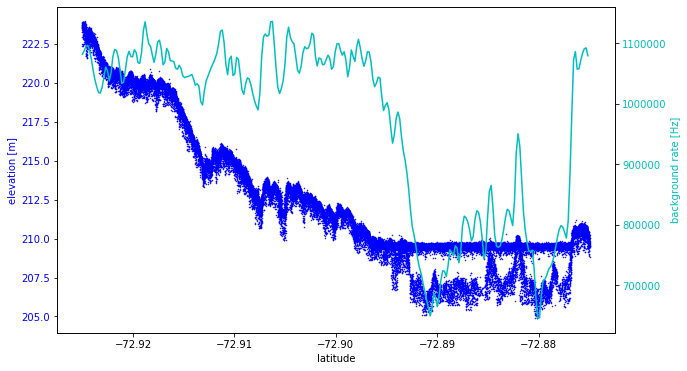

In [56]:
with h5py.File('/home/jovyan/ATL06/ATL06_20190102184312_00810210_001_01.h5') as f:
    elev_atl06 = f['/gt2l/land_ice_segments/h_li'][:]
    lat_atl06 = f['/gt2l/land_ice_segments/latitude'][:]
    background_atl06 = f['/gt2l/land_ice_segments/geophysical/bckgrd'][:]
    f.close()

%matplotlib inline
f1, ax = plt.subplots(figsize=(10,6))

ax.plot(lat_atl03[subset1], elev_atl03[subset1], 'b.', markersize=1)
ax.set_xlabel('latitude')
ax.set_ylabel('elevation [m]', color='b')
ax.tick_params(axis='y', labelcolor='b')
#ax[0].set_ylim(204.5,223)

ax2 = ax.twinx()
ax2.plot(lat_atl06[subset2], background_atl06[subset2], 'c')
ax2.set_ylabel('background rate [Hz]', color='c')
ax2.tick_params(axis='y', labelcolor='c')

#testharder
#f1.tight_layout
plt.show()

Exciting! It looks like background rates decrease significantly over melt ponds. This calls for more analysis...

Celebrate success!